In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

In [2]:
n_samples = 1500
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)

In [3]:
moon_x, moon_y = noisy_moons
moon_x = StandardScaler().fit_transform(moon_x)

In [4]:
colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a",
                    "#f781bf",
                ]
            ),
            int(max(moon_y) + 1),
        )
    )
)

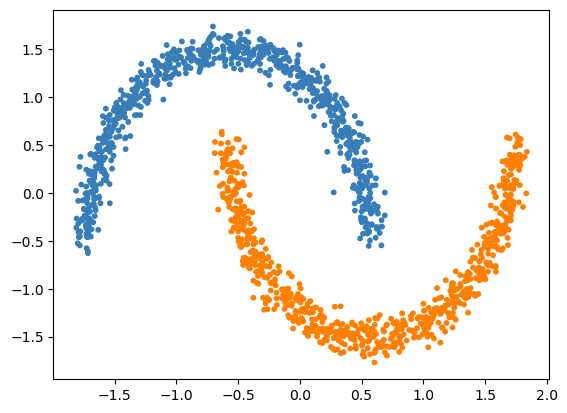

In [5]:
plt.scatter(moon_x[:,0], moon_x[:,1], color = colors[moon_y], s = 10)

In [6]:
import torch
import torch.nn as nn
import os, sys
from tony_dataset import CTGdataset, CleanDataset
from neural_net import Neural_Net, train_nn
torch.manual_seed(0)

In [7]:
Clean_Dataset = CleanDataset(moon_x, moon_y)

train_dataset, test_dataset = torch.utils.data.random_split(Clean_Dataset, 
    [int(0.9 * len(Clean_Dataset)), len(Clean_Dataset) - int(0.9 * len(Clean_Dataset))])
# training vs testing ratio is 6:4

In [8]:
grid_x = np.mgrid[-6:6:240j, -6:6:240j].reshape(2,-1).T
y = np.zeros(grid_x.shape[0])
grid_dataset = CleanDataset(grid_x, y)

In [9]:
def generate_data(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=len(test_dataset), 
                                            shuffle=True)
    # Iterate through test dataset, calculate testing accuracy
    for samples, labels in test_loader:
        outputs = model(samples)
        _, predicted = torch.max(outputs.data, 1)
    return samples, predicted

In [45]:
# Instantiate model class
input_dim = 2  # 2-dimensional space
hidden_dim = 120
output_dim = 2 # True or False - binary output
dropout_rate = 0.0
model = Neural_Net(input_dim, hidden_dim, output_dim, dropout_rate)

orig_stdout = sys.stdout

# Warmstart the neural networks
filepath = '../synthetic_data/2D/NN_generate_log.txt'
os.makedirs(os.path.dirname(filepath), exist_ok = True)

with open(filepath, 'w') as sys.stdout:
    batch_size = 50
    train_nn(model, train_dataset, test_dataset, batch_size = batch_size, l_r = 0.001, num_epochs = 100,
            optimizerName = "Adam")
    # Old comment
    # num_epochs is chosen to make the test accuracies of all 6 NN models to be less than 50%,
    # so that these models don't end up simply replicating the dataset

# Generate synthetic data with the neural networks
x, y = generate_data(model, grid_dataset)
x_df, y_df = pd.DataFrame(x.numpy()), pd.DataFrame(y.numpy())
x_df.to_csv('../synthetic_data/2D/NN_x.csv', index=False, header=False)
y_df.to_csv('../synthetic_data/2D/NN_y.csv', index=False, header=False)

sys.stdout = orig_stdout

In [46]:
NN_x = pd.read_csv("../synthetic_data/2D/NN_x.csv", header = None)
NN_y = pd.read_csv("../synthetic_data/2D/NN_y.csv", header = None)
NN_x, NN_y = np.array(NN_x), (np.array(NN_y)).flatten()

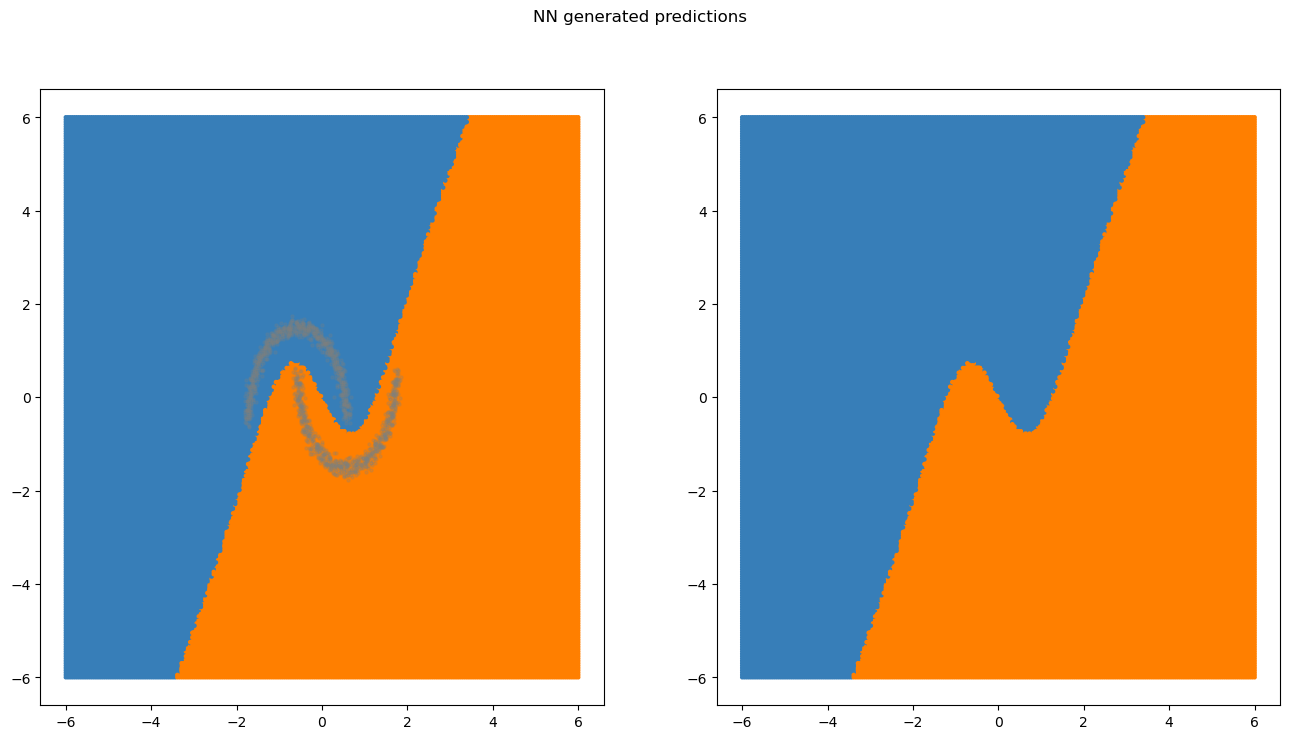

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('NN generated predictions')
fig

ax1.scatter(NN_x[:,0], NN_x[:,1], color = colors[NN_y], s = 5)
ax1.scatter(moon_x[:,0], moon_x[:,1], color = 'gray', s = 5, alpha = 0.2)

ax2.scatter(NN_x[:,0], NN_x[:,1], color = colors[NN_y], s = 5)

In [48]:
# context manager - used with "with" statement
# result: the added path is removed after execution of the indented block
class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass

In [69]:
with add_path('../'):
    from scikit_obliquetree.HHCART import HouseHolderCART
    from scikit_obliquetree.segmentor import MeanSegmentor, TotalSegmentor, Gini
    from sklearn.metrics import accuracy_score

    sgmtr = TotalSegmentor()
    HHTree = HouseHolderCART(impurity = Gini(), segmentor = sgmtr, max_depth = 5, min_samples = 10)
    HHTree.fit(moon_x, moon_y)
    train_score = accuracy_score(moon_y, HHTree.predict(moon_x))
    print("train_score: ", train_score)
    grid_y_pred = HHTree.predict(grid_x)
    grid_y_pred = grid_y_pred.astype(int)


train_score:  0.9986666666666667


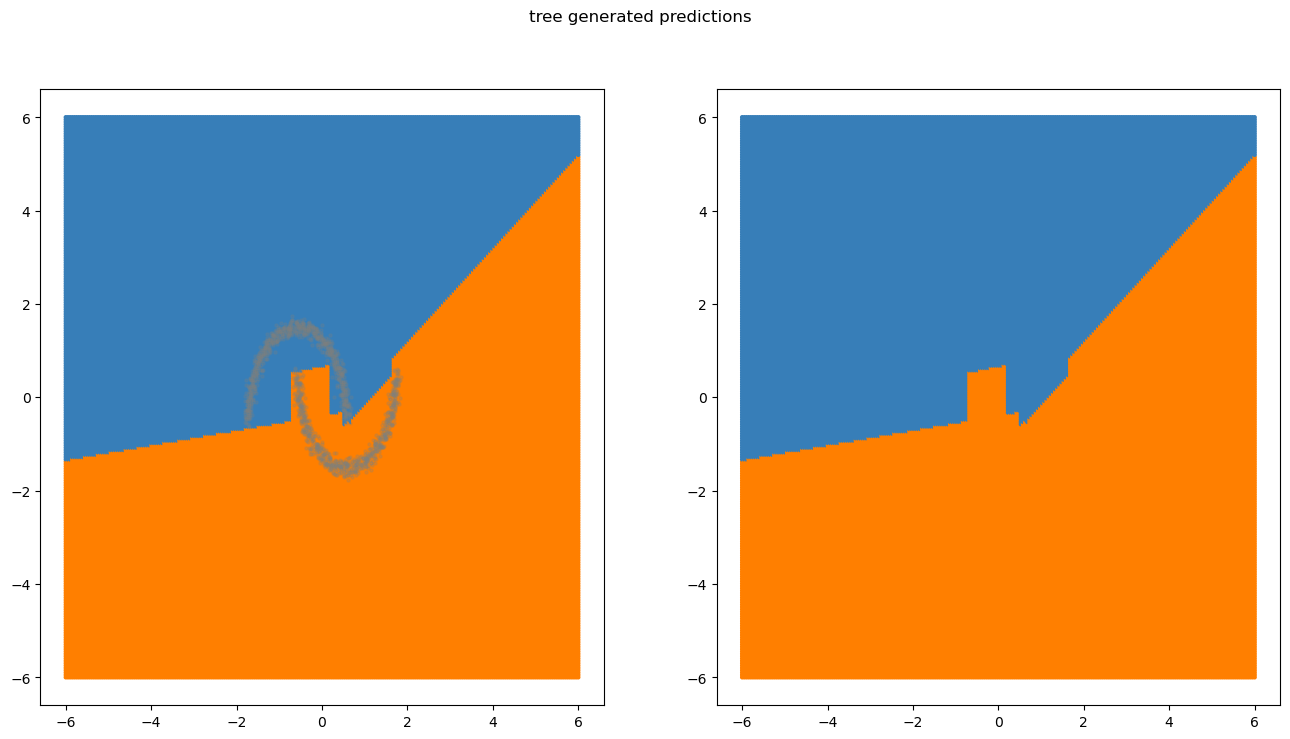

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('tree generated predictions')
fig

ax1.scatter(grid_x[:,0], grid_x[:,1], color = colors[grid_y_pred], s = 5)
ax1.scatter(moon_x[:,0], moon_x[:,1], color = 'gray', s = 5, alpha = 0.2)

ax2.scatter(grid_x[:,0], grid_x[:,1], color = colors[grid_y_pred], s = 5)